In [1]:
from pathlib import Path
from util import NUMBER_REGEX
import numpy as np

simon_dir = "sim/simon_simulations_20220714_continue/"
simon_path = Path(simon_dir)

In [2]:
sims = {}

c = 0
def p(*args, **kwargs):
    global c
    if c < 10:
        print(*args, **kwargs)
        c += 1

for sim_path in simon_path.glob("iopf_sim*"):
    label = sim_path.name
    slabel = label.split("_")
    drag_coefficient = int(slabel[slabel.index('DRAG')+1][0])
    n_particles = int(slabel[slabel.index('N')+1])
    seed = int(slabel[-1])

    output_path = sim_path / "output.txt"
    with open(output_path, "r") as output_file:
        _t = 0
        _sysT = 0
        L = []
        for line in output_file:
            if line.startswith("t = "):
                t, N, sysT, *_ = map(float, NUMBER_REGEX.findall(line))

                if sysT > _sysT:
                    dt = t - _t
                    dsysT = sysT - _sysT
                    L.append((N, dt/dsysT))

                _t = t
                _sysT = sysT
    
    sims[(drag_coefficient, n_particles, seed)] = {
        "label": label,
        "drag_coefficient": drag_coefficient,
        "n_particles": n_particles,
        "seed": seed,
        "path": sim_path,
        "runtimes": np.array(L)
    }

    print(f"{label} {drag_coefficient=} {n_particles=} {seed=}")
    print()

iopf_sim_DRAG_0.0_N_100_47220 drag_coefficient=0 n_particles=100 seed=47220

iopf_sim_DRAG_0.0_N_100_61392 drag_coefficient=0 n_particles=100 seed=61392

iopf_sim_DRAG_1.0_N_100_47220 drag_coefficient=1 n_particles=100 seed=47220

iopf_sim_DRAG_1.0_N_100_61392 drag_coefficient=1 n_particles=100 seed=61392

iopf_sim_DRAG_0.0_N_100_92718 drag_coefficient=0 n_particles=100 seed=92718

iopf_sim_DRAG_1.0_N_100_92718 drag_coefficient=1 n_particles=100 seed=92718

iopf_sim_DRAG_0.0_N_100_29381 drag_coefficient=0 n_particles=100 seed=29381

iopf_sim_DRAG_1.0_N_100_29381 drag_coefficient=1 n_particles=100 seed=29381



In [3]:
sims.keys()

dict_keys([(0, 100, 47220), (0, 100, 61392), (1, 100, 47220), (1, 100, 61392), (0, 100, 92718), (1, 100, 92718), (0, 100, 29381), (1, 100, 29381)])

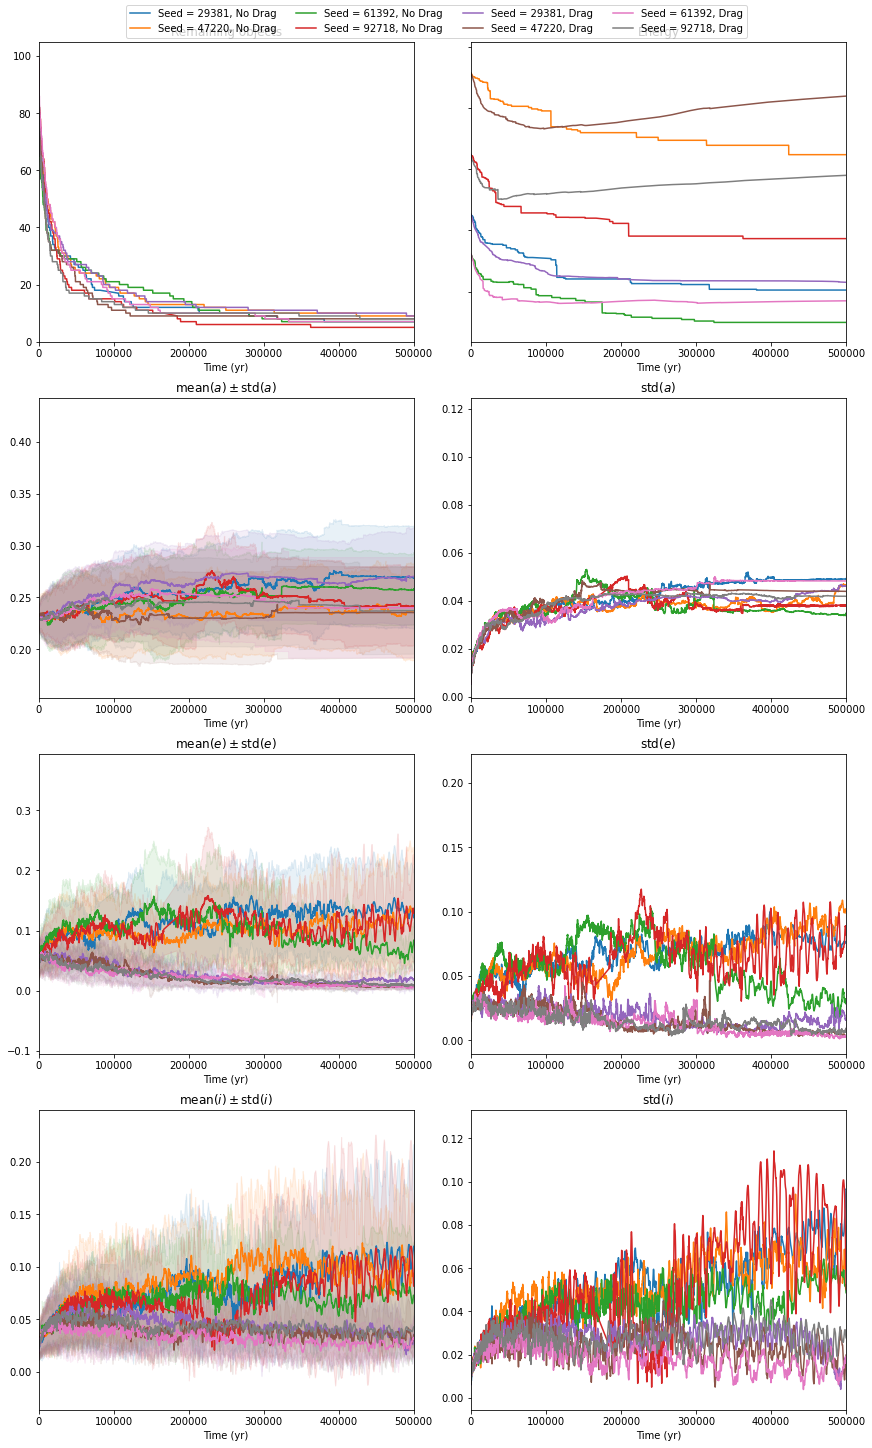

In [5]:
import matplotlib.pyplot as plt
import h5py
import util

def make_label(k):
    if k[0] == 1:
        return f"Seed = {k[2]}, Drag"
    if k[0] == 0:
        return f"Seed = {k[2]}, No Drag"

def plot_remaining_over_time(ax, steps, **kwargs):
    remaining = []
    time = []
    for step in steps:
        time.extend(step["time"])
        remaining.extend(np.sum(~np.isnan(step["mass"]), axis=1) - 1)

    ax.plot(time, np.array(remaining), **kwargs)

    # ax.legend()
    ax.set_xlim(0, 500000)
    ax.set_title(rf"Remaining objects")
    ax.set_xlabel("Time (yr)")

    ax.set_ylim(0, 105)

def plot_energy_over_time(ax, steps, **kwargs):
    E = []
    time = []
    for step in steps:
        time.extend(step["time"])
        E.extend(step["energy"])

    ax.plot(time, np.array(E), **kwargs)

    # ax.legend()
    ax.set_xlim(0, 500000)
    ax.set_title(rf"Energy")
    ax.set_xlabel("Time (yr)")

    ax.set_yticklabels([])


def plot_over_time(ax, steps, column, mathtext, **kwargs):
    std_e = []
    mean_e = []
    # min_e = []
    # max_e = []

    time = []
    for step in steps:
        time.extend(step["time"])
        data = step[column][:, 1:]
        std_e.extend(np.nanstd(data, axis=1))
        mean_e.extend(np.nanmean(data, axis=1))
        # min_e.extend(np.percentile(data, 25, axis=1))
        # max_e.extend(np.percentile(data, 75, axis=1))

    ax.plot(time, np.array(mean_e), **kwargs)
    ax.fill_between(time, np.array(mean_e) - np.array(std_e), np.array(mean_e) + np.array(std_e), alpha=0.1, ec="face")
    # ax.fill_between(time, np.array(min_e), np.array(max_e), alpha=0.1, ec="face")

    # ax.legend()
    ax.set_xlim(0, 500000)
    ax.set_title(rf"$\mathrm{{mean}}({mathtext}) \pm \mathrm{{std}}({mathtext})$")
    ax.set_xlabel("Time (yr)")
    

def plot_std_over_time(ax, steps, column, mathtext, **kwargs):
    std_e = []
    time = []
    for step in steps:
        time.extend(step["time"])
        data = step[column][:, 1:]
        std_e.extend(np.nanstd(data, axis=1))
    ax.plot(time, np.array(std_e), **kwargs)

    # ax.legend()
    ax.set_xlim(0, 500000)
    ax.set_title(rf"$\mathrm{{std}}({mathtext})$")
    ax.set_xlabel("Time (yr)")


def double_plot(axs, steps, column, mathtext, **kwargs):
    plot_over_time(axs[0], steps, column, mathtext, **kwargs)
    plot_std_over_time(axs[1], steps, column, mathtext, **kwargs)


fig, axs = plt.subplots(4, 2, figsize=(12, 20), constrained_layout=True)

for k, v in sorted(sims.items()):
    if v["n_particles"] > 50:
        f = h5py.File(v["path"] / f"data_reb_{k[2]}.h5", "r")
        sorted_steps = util.sorted_steps(f)
        plot_remaining_over_time(axs[0][0], sorted_steps, label=make_label(k))
        plot_energy_over_time(axs[0][1], sorted_steps, label=make_label(k))
        double_plot(axs[1], sorted_steps, "a", "a", label=make_label(k))
        double_plot(axs[2], sorted_steps, "ecc", "e", label=make_label(k))
        double_plot(axs[3], sorted_steps, "inc", "i", label=make_label(k))

fig.suptitle("Time evolution of orbits (N=100)", alpha=0)

plt.figlegend(handles=axs[0][0].get_lines(), ncol=4, loc="upper center", frameon=True)


In [58]:
import rebound

def open_rebound_sa(sim_data, snapshot=-1):
    return rebound.SimulationArchive(str(sim_data["path"] / f"rebound_archive.bin"))


# for k, v in sims.items():
#     if v["n_particles"] > 50 and v["drag_coefficient"] == 1:
#         sim = rebound.Simulation(str(v["path"] / f"rebound_archive.bin"), -1)
#         rebound.OrbitPlot(sim)

reb_sim_archive = open_rebound_sa(sims[(1, 100, 47220)])

In [3]:
from ipywidgets import interact
from IPython.display import display
from ctypes import pointer
import rebound

def open_rebound_sa(sim_data, snapshot=-1):
    return rebound.SimulationArchive(str(sim_data["path"] / f"rebound_archive.bin"))

reb_sim_archive = open_rebound_sa(sims[(1, 100, 47220)])
init_sim = reb_sim_archive[0]
w = init_sim.getWidget(size=(500, 500), scale=0.25)

# @interact(time=(0, 1000000))
# def update_widget(time):
#     _sim = reb_sim_archive.getSimulation(time)
#     w.refresh(pointer(_sim))

# display(w)


/home/alchzh/cassum-2022-project-21/workspace/src/rebound/rebound/simulationarchive.py:99: RuntimeWarning: The binary file seems to be corrupted. An attempt has been made to read the uncorrupted parts of it.
  warnings.warn(message, RuntimeWarning)
/home/alchzh/cassum-2022-project-21/workspace/src/rebound/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


interactive(children=(IntSlider(value=500000, description='time', max=1000000), Output()), _dom_classes=('widg…

: 

: 